# Project: Monthly Armed Robberies in Boston

Author: Jason Brownlee


We will work through a **time series forecasting project from end-to-end**, from
downloading the dataset and defining the problem to training a final model and making
predictions. This project is not exhaustive, but **shows how you can get good results quickly by
working through a time series forecasting problem systematically**. The steps of this project that
we will work through are as follows:


1. Problem Description.
2. Test Harness.
3. Persistence.
4. Data Analysis.
5. ARIMA Models.
6. Model Validation.


## Problem Description


The problem is to predict the number of monthly armed robberies in Boston, USA. The dataset
provides the number of monthly armed robberies in Boston from January 1966 to October 1975,
or just under 10 years of data. The values are a count and there are 118 observations. The
dataset is credited to McCleary and Hay (1980)


### Test Harness


We must develop a test harness to investigate the data and evaluate candidate models. This
involves two steps:

1. Defining a Validation Dataset.
2. Developing a Method for Model Evaluation.


#### Validation Dataset


The dataset is not current. This means that **we cannot easily collect updated data to validate
the model**. Therefore we will pretend that it is October 1974 and withhold **the last one year of
data from analysis and model selection**. This final year of data will be used to validate the final
model. The code below will load the dataset as a Pandas Series and split into two, one for
model development (dataset.csv) and the other for validation (validation.csv)


In [1]:
# split into a training and validation dataset
from pandas import read_csv

series = read_csv("robberies.csv", header=0, index_col=0, parse_dates=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print("Dataset %d, Validation %d" % (len(dataset), len(validation)))
dataset.to_csv("dataset.csv")

Dataset 106, Validation 12


In [2]:
len(series)

118

In [3]:
split_point

106

In [4]:
validation.to_csv("validation.csv")

Running the example creates two files and prints the number of observations in each.


The specific contents of these files are:

- dataset.csv: Observations from January 1966 to October 1974 (106 observations)
- validation.csv: Observations from November 1974 to October 1975 (12 observations)

The validation dataset is 10% of the original dataset. Note that the saved datasets do not
have a header line, therefore we do not need to cater to this when working with these files later.


#### Model Evaluation


Model evaluation will only be performed on the data in dataset.csv prepared in the previous
section. Model evaluation involves two elements:

1. Performance Measure.
2. Test Strategy.


##### Performance Measure


The observations are a count of robberies. We will evaluate the performance of predictions using
the root mean squared error **(RMSE)**. This will give **more weight to predictions that are grossly
wrong** and will have the same units as the original data. Any transforms to the data must be
reversed before the RMSE is calculated and reported to make the performance between different
methods directly comparable.

We can calculate the RMSE using the helper function from the scikit-learn library mean squared error()

that calculates the mean squared error between a list of expected values (the test set) and the
list of predictions. We can then take the square root of this value to give us an RMSE score.
For example


In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# ...
# test = ...
# predictions = ...
# mse = mean_squared_error(test, predictions)
# rmse = sqrt(mse)
# print('RMSE: %.3f' % rmse)

##### Test Strategy


**Candidate models will be evaluated using walk-forward validation**. This is because a rolling forecast type model is required from the problem definition. This is where one-step forecasts
are needed given all available data. The walk-forward validation will work as follows:

1. The first 50% of the dataset will be held back to train the model.
2. The remaining 50% of the dataset will be iterated and test the model.
3. For each step in the test dataset:

   (a) A model will be trained.

   (b) A one-step prediction made and the prediction stored for later evaluation.

   (c) The actual observation from the test dataset will be added to the training dataset for the next iteration.

The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

Given the small size of the data, we will allow a model to be re-trained given all available
data prior to each prediction. We can write the code for the test harness using simple NumPy
and Python code. Firstly, we can split the dataset into train and test sets directly. We’re careful
to always convert a loaded dataset to float32 in case the loaded data still has some String or
Integer data types.


In [6]:
# prepare data
X = series.values
X = X.astype("float32")
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

Next, **we can iterate over the time steps in the test dataset**. The train dataset is stored in a
Python list as we need to easily append a new observation each iteration and NumPy array
concatenation feels like overkill. The prediction made by the model is called yhat for convention,
as the outcome or observation is referred to as **y and yhat (a y with a mark above)** is the
mathematical notation for the prediction of the y variable. The prediction and observation are
printed each observation for a sanity check prediction in case there are issues with the model.


In [7]:
# walk-forward validation
# history = [x for x in train]
# predictions = list()
# for i in range(len(test)):
# predict
# yhat = ...
# predictions.append(yhat)
# observation
# obs = test[i]
# history.append(obs)
# print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

##### Persistence


**The first step** before getting bogged down in data analysis and modeling **is to establish a baseline
of performance**. This will provide both a template for evaluating models using the proposed
test harness and a performance measure by which all more elaborate predictive models can be
compared. **The baseline prediction for time series forecasting is called the naive forecast**, or
persistence. This is where the observation from the previous time step is used as the prediction
for the observation at the next time step. We can plug this directly into the test harness defined
in the previous section. The complete code listing is provided below.


In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [9]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print(">Predicted=%.3f, Expected=%3.f" % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print("RMSE: %.3f" % rmse)

>Predicted=174.000, Expected=178
>Predicted=178.000, Expected=136
>Predicted=136.000, Expected=161
>Predicted=161.000, Expected=171
>Predicted=171.000, Expected=149
>Predicted=149.000, Expected=184
>Predicted=184.000, Expected=155
>Predicted=155.000, Expected=276
>Predicted=276.000, Expected=224
>Predicted=224.000, Expected=213
>Predicted=213.000, Expected=279
>Predicted=279.000, Expected=268
>Predicted=268.000, Expected=287
>Predicted=287.000, Expected=238
>Predicted=238.000, Expected=213
>Predicted=213.000, Expected=257
>Predicted=257.000, Expected=293
>Predicted=293.000, Expected=212
>Predicted=212.000, Expected=246
>Predicted=246.000, Expected=353
>Predicted=353.000, Expected=339
>Predicted=339.000, Expected=308
>Predicted=308.000, Expected=247
>Predicted=247.000, Expected=257
>Predicted=257.000, Expected=322
>Predicted=322.000, Expected=298
>Predicted=298.000, Expected=273
>Predicted=273.000, Expected=312
>Predicted=312.000, Expected=249
>Predicted=249.000, Expected=286
>Predicted

/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_71631/3924446686.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(">Predicted=%.3f, Expected=%3.f" % (yhat, obs))


Running the test harness prints the prediction and observation for each iteration of the test
dataset. The example ends by printing the RMSE for the model. In this case, we can see that
the persistence model achieved an RMSE of 54.191. This means that on average, the model was
wrong by about 54 robberies for each prediction made.


We now have a baseline prediction method and performance; now we can start digging into
our data


### Data Analysis


We can use summary statistics and plots of the data to quickly learn more about the structure
of the prediction problem. In this section, we will look at the data from four perspectives:

1. Summary Statistics.
2. Line Plot.
3. Density Plots.
4. Box and Whisker Plot.


#### Summary Statistics

Open the data dataset.csv file and/or the original robberies.csv file in a text editor and
look at the data. A quick check suggests that there are no obviously missing observations.
We may have noticed this earlier if we tried to force the series to floating point values and
values like NaN or ? were in the data. Summary statistics provide a quick look at the limits of
observed values. It can help to get a quick idea of what we are working with. The example
below calculates and prints summary statistics for the time series.


In [10]:
print(dataset.describe())

        Robberies
count  106.000000
mean   173.103774
std    112.231133
min     29.000000
25%     74.750000
50%    144.500000
75%    271.750000
max    487.000000


Running the example provides a number of summary statistics to review. Some observations
from these statistics include:

- The number of observations (count) matches our expectation, meaning we are handling
  the data correctly.
- The mean is about 173, which we might consider our level in this series.
- The standard deviation (average spread from the mean) is relatively large at 112 robberies.
- The percentiles along with the standard deviation do suggest a large spread to the data.


The large spread in this series will likely make highly accurate predictions difficult if it is
caused by random fluctuation (e.g. not systematic)


## Line Plot


A line plot of a time series can provide a lot of insight into the problem. The example below
creates and shows a line plot of the dataset.


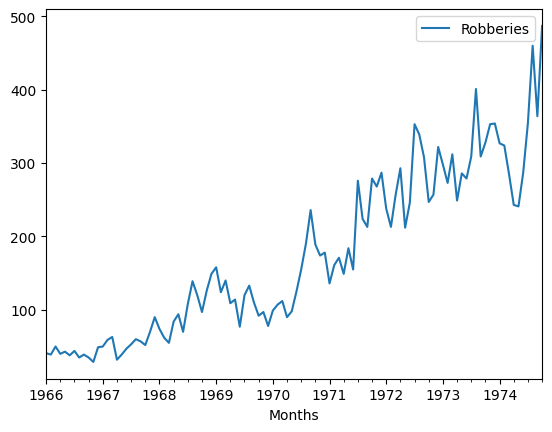

In [11]:
# line plots of time series
from matplotlib import pyplot

dataset.plot()
pyplot.show()

Run the example and review the plot. Note any obvious temporal structures in the series.
Some observations from the plot include:

- There is an increasing trend of robberies over time.
- There do not appear to be any obvious outliers.
- There are relatively large fluctuations from year to year, up and down.
- The fluctuations at later years appear larger than fluctuations at earlier years.
- The trend means the dataset is almost certainly non-stationary and the apparent change
  in fluctuation may also contribute


These simple observations suggest we may see benefit in modeling the trend and removing
it from the time series. Alternately, we could use differencing to make the series stationary
for modeling. We may even need two levels of differencing if there is a growth trend in the
fluctuations in later years.


## Density Plot


Reviewing plots of the density of observations can provide further insight into the structure of
the data. The example below creates a histogram and density plot of the observations without
any temporal structure.


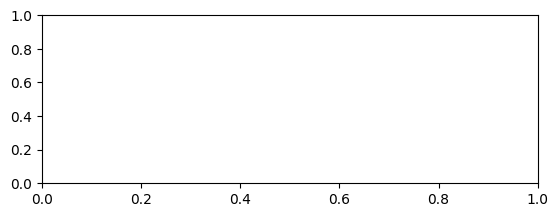

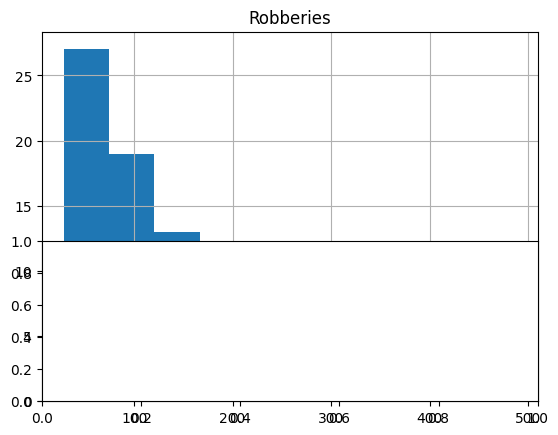

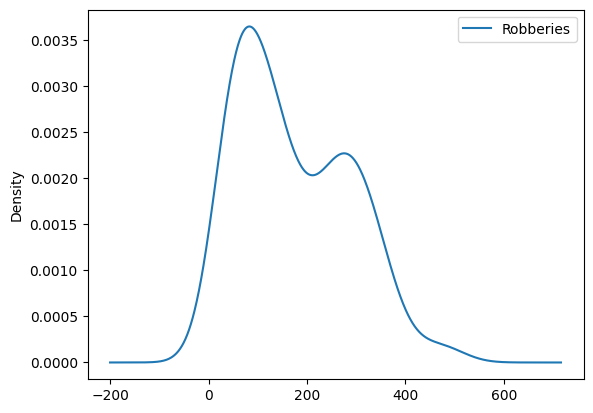

In [12]:
pyplot.figure(1)
pyplot.subplot(211)
dataset.hist()
pyplot.subplot(212)
dataset.plot(kind="kde")
pyplot.show()

Run the example and review the plots. Some observations from the plots include:

- The distribution is not Gaussian.
- The distribution is left shifted and may be exponential or a double Gaussian.


### Box and Whisker Plots


We can group the monthly data by year and get an idea of the spread of observations for each
year and how this may be changing. We do expect to see some trend (increasing mean or
median), but it may be interesting to see how the rest of the distribution may be changing. The
example below groups the observations by year and creates one box and whisker plot for each
year of observations. The last year (1974) only contains 10 months and may not be a useful
comparison with the other 12 months of observations in the other years. Therefore only data
between 1966 and 1973 was plotted


In [13]:
from pandas import Grouper
from pandas import DataFrame

In [14]:
print(dataset)
groups = dataset["1966":"1973"].groupby(Grouper(freq="A"))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
pyplot.show()

            Robberies
Months               
1966-01-01         41
1966-02-01         39
1966-03-01         50
1966-04-01         40
1966-05-01         43
...               ...
1974-06-01        287
1974-07-01        355
1974-08-01        460
1974-09-01        364
1974-10-01        487

[106 rows x 1 columns]


/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_71631/2429015860.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  groups = dataset["1966":"1973"].groupby(Grouper(freq="A"))


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

Running the example creates 8 box and whisker plots side-by-side, one for each of the 8
years of selected data. Some observations from reviewing the plot include:

- The median values for each year (red line) show a trend that may not be linear.
- The spread, or middle 50% of the data (blue boxes), differ, but perhaps not consistently
  over time.
- The earlier years, perhaps first 2, are quite different from the rest of the dataset


The observations suggest that the year-to-year fluctuations may not be systematic and hard
to model. They also suggest that there may be some benefit in clipping the first two years of
data from modeling if it is indeed quite different. This yearly view of the data is an interesting
avenue and could be pursued further by looking at summary statistics from year-to-year and
changes in summary stats from year-to-year. Next, we can start looking at predictive models of
the series.


### ARIMA Models


In this section, we will develop Autoregressive Integrated Moving Average, or ARIMA, models
for the problem. We will approach this in four steps:

1. Developing a manually configured ARIMA model.
2. Using a grid search of ARIMA to find an optimized model.
3. Analysis of forecast residual errors to evaluate any bias in the model.
4. Explore improvements to the model using power transforms


### Manually Configured ARIMA


Nonseasonal ARIMA(p,d,q) requires three parameters and is traditionally configured manually.
Analysis of the time series data assumes that we are working with a stationary time series. The
time series is almost certainly non-stationary. We can make it stationary by first differencing
the series and using a statistical test to confirm that the result is stationary. The example below
creates a stationary version of the series and saves it to file stationary.csv.


In [15]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller

In [16]:
# create a differenced time series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)


X = dataset.values
# difference data
stationary = difference(X)
stationary.index = dataset.index[1:]

# check if stationary
result = adfuller(stationary)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))
# save
stationary.to_csv("stationary.csv")

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


Running the example outputs the result of a statistical significance test of whether the 1-lag
differenced series is stationary. Specifically, the augmented Dickey-Fuller test. The results show
that the test statistic value -3.980946 is smaller than the critical value at 5% of -2.893. This
suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a
low probability that the result is a statistical fluke). Rejecting the null hypothesis means that
the process has no unit root, and in turn that the 1-lag differenced time series is stationary or
does not have time-dependent structure.


This suggests that at least one level of differencing is required. The d parameter in our
ARIMA model should at least be a value of 1. The next step is to select the lag values for
the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can
do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function
(PACF) plots. The example below creates ACF and PACF plots for the series.


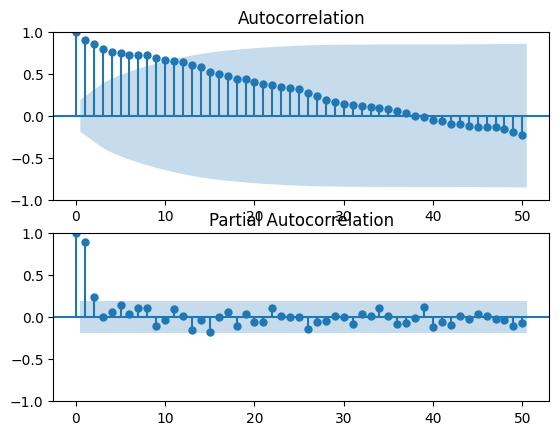

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure()
pyplot.subplot(211)
plot_acf(dataset, lags=50, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(dataset, lags=50, ax=pyplot.gca())
pyplot.show()

Run the example and review the plots for insights into how to set the p and q variables for
the ARIMA model. Below are some observations from the plots.

- The ACF shows a significant lag for 10-11 months.
- The PACF shows a significant lag for perhaps 2 months.
- Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

A good starting point for the p and q values is 1 or 2


This quick analysis suggests an ARIMA(2,1,10) on the raw data may be a good starting
point. Experimentation shows that this configuration of ARIMA does not converge and results
in errors by the underlying library, as do similarly large AR values. **Some experimentation shows
that the model does not appear to be stable**, with non-zero AR and MA orders defined at the
same time. **The model can be simplified to ARIMA(0,1,2)**. The example below demonstrates
the performance of this ARIMA model on the test harness.


In [18]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [19]:
# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print(">Predicted=%.3f, Expected=%3.f" % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print("RMSE: %.3f" % rmse)

/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_71631/1797921587.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(">Predicted=%.3f, Expected=%3.f" % (yhat, obs))


>Predicted=184.243, Expected=178
>Predicted=180.569, Expected=136
>Predicted=138.021, Expected=161
>Predicted=165.212, Expected=171
>Predicted=165.866, Expected=149
>Predicted=149.407, Expected=184
>Predicted=183.340, Expected=155
>Predicted=154.190, Expected=276
>Predicted=245.960, Expected=224
>Predicted=237.588, Expected=213
>Predicted=220.710, Expected=279
>Predicted=258.419, Expected=268
>Predicted=261.430, Expected=287
>Predicted=282.228, Expected=238
>Predicted=252.234, Expected=213
>Predicted=226.403, Expected=257
>Predicted=246.537, Expected=293
>Predicted=275.300, Expected=212
>Predicted=231.913, Expected=246
>Predicted=251.514, Expected=353
>Predicted=304.673, Expected=339
>Predicted=310.317, Expected=308
>Predicted=321.388, Expected=247
>Predicted=271.710, Expected=257
>Predicted=271.665, Expected=322
>Predicted=302.766, Expected=298
>Predicted=283.336, Expected=273
>Predicted=287.054, Expected=312
>Predicted=310.278, Expected=249
>Predicted=254.239, Expected=286
>Predicted

Running this example results in an RMSE of 51.007, which is lower than the persistence
model.


This is a good start, but we may be able to get improved results with a better configured
ARIMA model.


### Grid Search ARIMA Hyperparameters


Many ARIMA configurations are unstable on this dataset, but there may be other hyperparameters that result in a well-performing model. In this section, we will search values of p, d, and q
for combinations that do not result in error, and find the combination that results in the best
performance. We will use a grid search to explore all combinations in a subset of integer values.
Specifically, we will search all combinations of the following parameters:


- p: 0 to 12
- d: 0 to 3
- q: 0 to 12


This is (13 × 4 × 13), or 676, runs of the test harness and will take some time to execute.
The complete worked example with the grid search version of the test harness is listed below.


In [20]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [21]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype("float32")
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model


def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype("float32")
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print("ARIMA%s RMSE=%.3f" % (order, rmse))
                except:
                    continue
    print("Best ARIMA%s RMSE=%.3f" % (best_cfg, best_score))

In [22]:
# load dataset

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(dataset.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=154.962
ARIMA(0, 0, 1) RMSE=99.354
ARIMA(0, 0, 2) RMSE=92.068
ARIMA(0, 0, 3) RMSE=72.271
ARIMA(0, 1, 0) RMSE=51.844
ARIMA(0, 1, 1) RMSE=50.717
ARIMA(0, 1, 2) RMSE=51.115
ARIMA(0, 1, 3) RMSE=52.058
ARIMA(0, 2, 0) RMSE=80.321
ARIMA(0, 2, 1) RMSE=51.845
ARIMA(0, 2, 2) RMSE=50.454
ARIMA(0, 2, 3) RMSE=50.401
ARIMA(0, 3, 0) RMSE=136.690
ARIMA(0, 3, 1) RMSE=80.808
ARIMA(0, 3, 2) RMSE=53.418
ARIMA(0, 3, 3) RMSE=51.455
ARIMA(1, 0, 0) RMSE=53.244
ARIMA(1, 0, 1) RMSE=51.634
ARIMA(1, 0, 2) RMSE=51.955
ARIMA(1, 0, 3) RMSE=52.974
ARIMA(1, 1, 0) RMSE=50.784
ARIMA(1, 1, 1) RMSE=50.364
ARIMA(1, 1, 2) RMSE=51.698
ARIMA(1, 1, 3) RMSE=52.244
ARIMA(1, 2, 0) RMSE=68.240
ARIMA(1, 2, 1) RMSE=50.641
ARIMA(1, 2, 2) RMSE=52.264
ARIMA(1, 2, 3) RMSE=50.501
ARIMA(1, 3, 0) RMSE=106.142
ARIMA(1, 3, 1) RMSE=68.713
ARIMA(1, 3, 2) RMSE=52.878
ARIMA(1, 3, 3) RMSE=53.287
ARIMA(2, 0, 0) RMSE=52.100
ARIMA(2, 0, 1) RMSE=52.332
ARIMA(2, 0, 2) RMSE=52.492
ARIMA(2, 0, 3) RMSE=52.945
ARIMA(2, 1, 0) RMSE=51.20

In [23]:
from IPython.display import Image

In [24]:
Image(filename="ARIMA1result.png", width=300, height=200)

FileNotFoundError: [Errno 2] No such file or directory: 'ARIMA1result.png'

In [ ]:
Image(filename="BestARIMA.png", width=300, height=200)

: 

### Review Residual Errors


A good final check of a model is to review residual forecast errors. Ideally, the distribution
of residual errors should be a Gaussian with a zero mean. We can check this by plotting the
residuals with a histogram and density plots. The example below calculates the residual errors
for predictions on the test set and creates these density plots.


In [ ]:
# plot residual errors for ARIMA model

from pandas import DataFrame
from matplotlib import pyplot

# prepare data
X = dataset.values
X = X.astype("float32")
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(0, 1, 2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)

# errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)

: 

In [ ]:
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind="kde", ax=pyplot.gca())
pyplot.show()

: 

Running the example creates the two plots. The graphs suggest a Gaussian-like distribution
with a longer right tail. This is perhaps a sign that the predictions are biased, and in this case
that perhaps a power-based transform of the raw data before modeling might be useful


It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal
structure in the data. The example below re-calculates the residual errors and creates ACF and
PACF plots to check for any significant autocorrelation.


In [ ]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.show()

: 

The results suggest that what little autocorrelation is present in the time series has been
captured by the model.


### Box-Cox Transformed Dataset


The Box-Cox transform is a method that is able to evaluate a suite of power transforms,
including, but not limited to, log, square root, and reciprocal transforms of the data. The
example below performs a log transform of the data and generates some plots to review the
effect on the time series.


In [ ]:
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

: 

In [ ]:
X = dataset.values
transformed, lam = boxcox(X)
print("Lambda: %f" % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line="r", ax=pyplot.gca())
pyplot.show()

: 

Running the example creates three graphs: a line chart of the transformed time series, a
histogram showing the distribution of transformed values, and a Q-Q plot showing how the
distribution of values compared to an idealized Gaussian distribution. Some observations from
these plots are follows:

- The large fluctuations have been removed from the line plot of the time series.
- The histogram shows a flatter or more uniform (well behaved) distribution of values.
- The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution


Undoubtedly, the Box-Cox transform has done something to the time series and may be
useful. Before proceeding to test the ARIMA model with the transformed data, we must have
a way to reverse the transform in order to convert predictions made with a model trained on
the transformed data back into the original scale. The boxcox() function used in the example
finds an ideal lambda value by optimizing a cost function. The lambda is used in the following function to transform the data:


$transform = log(x)$, If $lambda = 0$


$transform =  \frac{x^{\lambda}-1}{\lambda}$, IF $\lambda \neq 0$


This transform function can be reversed directly, as follows:


$x = \exp(transform)$, IF $\lambda = 0$


$x = \exp \left( \frac{(log(\lambda \times transform + 1)} {\lambda}\right)$, IF $\lambda \neq 0 $


In [ ]:
from scipy.stats import boxcox


# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

: 

We can re-evaluate the ARIMA(0,1,2) model with the Box-Cox transform. This involves
first transforming the history prior to fitting the ARIMA model, then inverting the transform
on the prediction before storing it for later comparison with the expected values. **The boxcox()
function can fail**. In practice, It has been seen this and it appears to be signaled by a returned
lambda value of less than -5. By convention, **lambda values are evaluated between -5 and 5**.
A check is added for a lambda value less than -5, and if this the case, a lambda value of 1
is assumed and the raw history is used to fit the model. **A lambda value of 1 is the same as
no-transform** and therefore the inverse transform has no effect. The complete example is listed
below.


In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox

: 

In [ ]:
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)


# prepare data
X = dataset.values
X = X.astype("float32")
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(0, 1, 2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print(">Predicted=%.3f, Expected=%3.f" % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print("RMSE: %.3f" % rmse)

: 

These can be ignored for now. The final RMSE of the model on the transformed data was
49.103. This is a smaller error than the ARIMA model on untransformed data, but only slightly,
and it may or may not be statistically different.


We will use this model with the Box-Cox transform as the final model.


### Model Validation


After models have been developed and a final model selected, it must be validated and finalized.
Validation is an optional part of the process, but one that provides a last check to ensure we have not fooled or lied to ourselves. This section includes the following steps:

- Finalize Model: Train and save the final model.
- Make Prediction: Load the finalized model and make a prediction.
- Validate Model: Load and validate the final model


Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a
transformed version of the entire dataset. Once fit, the model can be saved to file for later use.
Because a Box-Cox transform is also performed on the data, we need to know the chosen lambda
so that any predictions from the model can be converted back to the original, untransformed
scale. The example below fits an ARIMA(0,1,2) model on the Box-Cox transform dataset and
saves the whole fit object and the lambda value to file.


In [ ]:
import numpy


# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog), (self.k_lags, self.k_diff, self.k_ma))


ARIMA.__getnewargs__ = __getnewargs__


# prepare data
X = dataset.values
X = X.astype("float32")
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0, 1, 2))
model_fit = model.fit()

# save model
model_fit.save("model.pkl")
numpy.save("model_lambda.npy", [lam])

: 

model.pkl This is the ARIMAResult object from the call to ARIMA.fit().

This includes the coefficients and all other internal data returned when fitting the model.


model_lambda.npy This is the lambda value stored as a one-row, one-column NumPy
array


### Make Prediction


A natural case may be to load the model and make a single forecast. This is relatively straight-forward and involves restoring the saved model and the lambda and calling the forecast()
function. **The example below loads the model, makes a prediction for the next time step, inverses
the Box-Cox transform, and prints the prediction**.


In [ ]:
# load the finalized model and make a prediction
from statsmodels.tsa.arima.model import ARIMAResults
from math import exp
from math import log
import numpy


# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)


model_fit = ARIMAResults.load("model.pkl")
lam = numpy.load("model_lambda.npy")
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)

print("Predicted: %.3f" % yhat)

: 

Running the example prints the prediction of about 452. If we peek inside validation.csv,
we can see that the value on the first row for the next time period is 452. The model got it
100% correct, which is very impressive (or lucky).


We can load the model and use it in a pretend operational manner. In the test harness section,
we saved the final 12 months of the original dataset in a separate file to validate the final model.
We can load this validation.csv file now and use it see how well our model really is on unseen
data. There are two ways we might proceed:

- Load the model and use it to forecast the next 12 months. The forecast beyond the first
  one or two months will quickly start to degrade in skill.
- Load the model and use it in a rolling-forecast manner, updating the transform and model
  for each time step. This is the preferred method as it is how one would use this model in
  practice, as it would achieve the best performance.

We will make predictions in a rolling-forecast
manner. This means that we will step over lead times in the validation dataset and take the
observations as an update to the history.


In [ ]:
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)


# load and prepare datasets

X = dataset.values.astype("float32")
history = [x for x in X]

y = validation.values.astype("float32")
# load model
model_fit = ARIMAResults.load("model.pkl")
lam = numpy.load("model_lambda.npy")
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print(">Predicted=%.3f, Expected=%3.f" % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(0, 1, 2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print(">Predicted=%.3f, Expected=%3.f" % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print("RMSE: %.3f" % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color="red")
pyplot.show()

: 

Running the example prints each prediction and expected value for the time steps in the
validation dataset. The final RMSE for the validation period is predicted at 53 robberies. This
is not too different to the expected error of 49, but I would expect that it is also not too different
from a simple persistence model


A plot of the predictions compared to the validation dataset is also provided. The forecast
does have the characteristic of a persistence forecast. This does suggest that although this time
series does have an obvious trend, it is still a reasonably difficult problem.
